Dataset link : 
https://www.kaggle.com/datasets/riteskkr/holiday

### Introduction
in this project we will implement an image search engine which help us in image retrieval queries. the system will take an image as an input and retrieve the most relevant images related to the input image.

## Steps to build the Image Search Engine
#### 1- Define  Image Descriptor function
#### 2- Extracting Features from  Dataset (Indexing)
#### 3- Implement search function and Similarity metric
#### 4- Performing a real Search

<br>
<br>
<br>
<br>
<br>

In [ ]:
# import the necessary packages
import numpy as np
import cv2
import imutils
import glob
import cv2
import csv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

## Step 1 : Define Image Descriptor function
- In this Step we will define and implement the image_describe function.
- We will choose which features We take them into account when extracting the features from images.
- Decide what aspect of the image we want to describe for example:the color of the image or The shape of an object in the image

In [ ]:
# function used to describe images 

def image_describe(image,bins=(8,12,3)):
    # get the the dimensions of the image
    (h, w) = image.shape[:2]
    # compute the center of the image
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    # convert image from RGB to HSV color space  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []
    #####################################################################################
    
    # applying some preprocessing tricks for getting more robust and powerful model
    
    # divide the image into four pieces/segments(four rectangles)
    # top-left, top-right, bottom-right, bottom-left
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),(0, cX, cY, h)]
    # draw an elliptical mask at the center of the image
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    
    #loop over the 4-rectangles of the image
    for (startX, endX, startY, endY) in segments:
        # draw a mask for each corner of the image
        cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        # subtract the corner mask from the elliptical center
        cornerMask = cv2.subtract(cornerMask, ellipMask)
        
        
        # feature extraction >> by extracting the histogram colors from the image and create the feature vector
        hist = histogram(image, cornerMask,bins)
        # save the histogram colors into features list
        features.extend(hist)
        # extract a color histogram from the elliptical region and
        # update the feature vector
    hist = histogram(image, ellipMask)
    features.extend(hist)
    # return the feature vector
    return features

In [ ]:
#function used to calculate the histogram of the image 
def histogram(image, mask,bins=(8,12,3)):
    # create a 3D color histogram from the masked region of the image
    hist = cv2.calcHist([image], [0, 1, 2], mask, bins,
        [0, 180, 0, 256, 0, 256])
    # normalize the histogram if we are using OpenCV 2.4
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()
    # otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

## Step 2 : Extracting Features from  Dataset (Indexing)
- After implementing the image_describe function, now we will apply this function to our dataset to extract features of all images.
- save the features in a file to be used after that in simlarites comparing.

In [ ]:
# indexing images step 
dataset_path = input("Enter the Path of the folder that contains the images to be indexed ")
indexed_images_path = input("Enter the Path to where the computed index will be stored ")

# open the output index file for writing
output = open(indexed_images_path, "w")

# loop over images from the path entered before
for imagePath in glob.glob(dataset_path + "/*.jpg"):
    # extract the image ID from the image path 
    imageID = imagePath[imagePath.rfind("/") + 1:]
    # load the image 
    image = cv2.imread(imagePath)
    # describe the image
    features = image_describe(image)
    # write the features to the opened file
    features = [str(f) for f in features]
    output.write("%s,%s\n" % (imageID, ",".join(features)))
# close the index file
output.close()

Enter the Path of the folder that contains the images to be indexed C:\\Users\\MALRQ\\Downloads\\dataset-train
Enter the Path to where the computed index will be stored indexed-dataset.csv


## Step 3 : Implement search function and Similarity metric
- In this step we implement a f search function to compare the features for similarity.
- Define similarity function to calculate the similarties between images.


In [ ]:
# function to apply search algorithm
def search(queryFeatures,file_path,limit = 6):
    # dictionary to store results
    results = {}
    
    # open the index file for reading
    with open(file_path) as f:
        # initialize the CSV reader
        file_reader = csv.reader(f)
        # loop over the rows in the index
        for row in file_reader:
            # parse out the image ID and features, then compute the
            # chi-squared distance between the features in our index
            # and our query features
            features = [float(x) for x in row[1:]]
            d = chi2_distance(features, queryFeatures)
            # now that we have the distance between the two features
            # vectors, we can udpate the results dictionary 
            # the key is the current image ID in the index and the
            # value is the distance we just computed, representing
            # how 'similar' the imag e in the index is to our query
            results[row[0]] = d
        # close the reader
        f.close()
    # sort our results, so that the smaller distances (i.e. the
    # more relevant images are at the front of the list)
    results = sorted([(v, k) for (k, v) in results.items()])
    # return our (limited) results
    return results[:limit]

In [ ]:
# function to calculate the chi2-squared distances to get the similarities between the images 
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])
    # return the chi-squared distance
    return d

## Step 4 : Performing a real Search
- The final Step of our System is to perform a an actual Search.
- the user will upload or submit a photo.
- then the system will extract features from this query image.
- apply our similarity function to compare the query features to the features already indexed.
- finally the system simply return the most relevant results according to our similarity function.

In [ ]:
# test 
# query_image_path = input('Ennter the query_image_path')
query_image_path = 'test/1.jpg'
query = cv2.imread(query_image_path)
features = image_describe(query)

query_results = search(features,'indexed-dataset.csv')

In [ ]:
# save the output images ID into a list to show them
result_ids = []
for (v,k) in query_results:
    result_ids.append(k)

In [ ]:
# read all images into a list
images = [mpimg.imread(image) for image in result_ids]

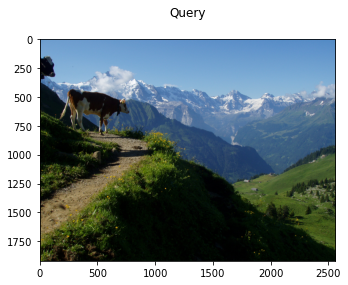

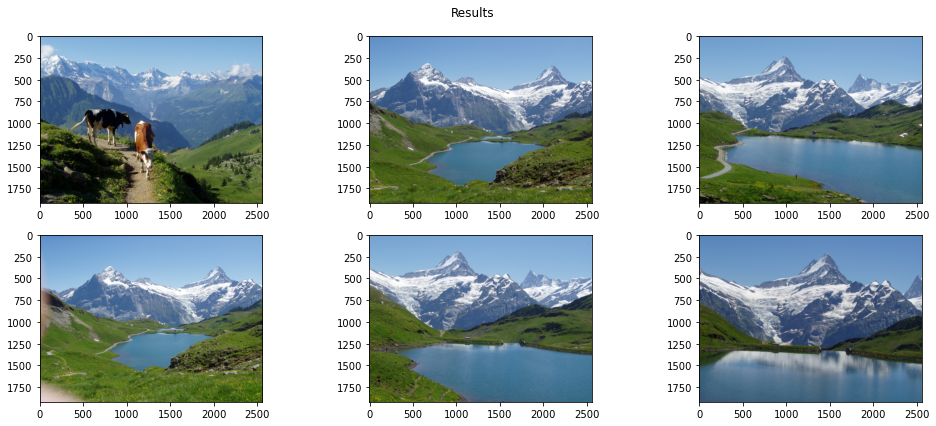

In [ ]:
# plot the query image and the Results
# plot query image
fig=plt.figure(figsize=(8, 4))
query_image = mpimg.imread(query_image_path)
plt.imshow(query_image)
fig.suptitle("Query")
plt.tight_layout()
plt.show()
#plot the results
fig=plt.figure(figsize=(14, 6))
fig.suptitle("Results")
# Define row and cols in the figure
rows, cols = 2, 3
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(images[j])
plt.tight_layout()
plt.show()